## 样式迁移
---

In [7]:
import torch
import torchsummary
import numpy as np
from torch import nn
from PIL import Image
from pathlib import Path
from torchvision import transforms
from torchvision import models
from matplotlib import pyplot as plt
%matplotlib inline

###  图片预览

In [8]:
def img_show(*imgs, row=1, col=2):
    fig, axes = plt.subplots(row, col, dpi=120)
    for ax, img in zip(axes, imgs):
        ax.imshow(img)
        ax.set_axis_off()  # 隐藏坐标轴
    fig.tight_layout()

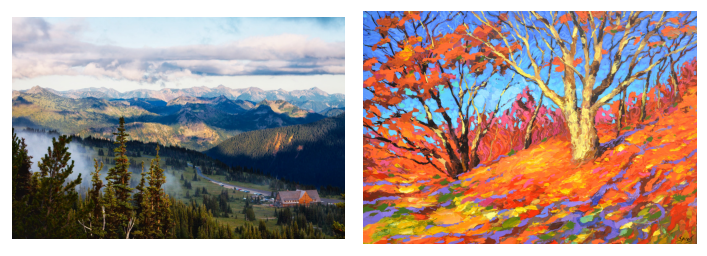

In [9]:
img_content_path = Path("./data/image/rainier.jpg")
img_style_path = Path("./data/image/autumn-oak.jpg")
with Image.open(img_content_path) as img1, Image.open(img_style_path) as img2:  # 使用上下文管理器打开文件
    img_show(img1, img2)

### 格式转换

In [4]:
# 定义格式转换(PIL->tensor)函数
def preprocess(img, size) -> torch.tensor:
    """
    此函数将PIL转换为张量

    Parameters
    ----------
    img : Image
        PIL格式图片
    size : int, arraylike
        目标尺寸，整数型或2D数组

    Returns
    -------
    torch.tensor
        输出张量
    """
    rgb_mean = [0.485, 0.456, 0.406]
    rgb_std = [0.229, 0.224, 0.225]
    transformer = transforms.Compose(
        [
            transforms.Resize(size),
            transforms.ToTensor(),
            transforms.Normalize(mean=rgb_mean, std=rgb_std),
        ]
    )
    return transformer(img).unsqueeze(0)

In [5]:
# 定义格式转换(tensor->PIl)函数
def postprocess(X: torch.tensor, device: torch.cuda.device) -> Image:
    """
    此函数将张量转换为PIL

    Parameters
    ----------
    X : torch.tensor
        4D张量，格式为(N, C, H, W)
    device : torch.cuda.device
        运算设备

    Returns
    -------
    Image : JPEG, png, ...
        输出PIL格式图片
    """
    rgb_mean = torch.tensor([0.485, 0.456, 0.406])  # 必须为张量且指定运算设备
    rgb_std = torch.tensor([0.229, 0.224, 0.225])
    X = X[0].to(device)
    X = torch.clamp(X.permute(1, 2, 0) * rgb_std + rgb_mean, 0, 1)
    transformer = transforms.ToPILImage()
    return transformer(X.permute(2, 0, 1))

### 预训练模型

In [6]:
vgg19 = models.vgg19(pretrained=True)  # 加载vgg19预训练模型
torchsummary.summary(vgg19, (3, 350, 450), device="cpu")  # 统计vgg19每层参数量

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1         [-1, 64, 350, 450]           1,792
              ReLU-2         [-1, 64, 350, 450]               0
            Conv2d-3         [-1, 64, 350, 450]          36,928
              ReLU-4         [-1, 64, 350, 450]               0
         MaxPool2d-5         [-1, 64, 175, 225]               0
            Conv2d-6        [-1, 128, 175, 225]          73,856
              ReLU-7        [-1, 128, 175, 225]               0
            Conv2d-8        [-1, 128, 175, 225]         147,584
              ReLU-9        [-1, 128, 175, 225]               0
        MaxPool2d-10         [-1, 128, 87, 112]               0
           Conv2d-11         [-1, 256, 87, 112]         295,168
             ReLU-12         [-1, 256, 87, 112]               0
           Conv2d-13         [-1, 256, 87, 112]         590,080
             ReLU-14         [-1, 256, 

### 特征抽取

In [7]:
net = vgg19.features[:29]  # 截取vgg19特征抽取层的前28层
device = "cuda" if torch.cuda.is_available() else "cpu"
net.to(device)

Sequential(
  (0): Conv2d(3, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (1): ReLU(inplace=True)
  (2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (3): ReLU(inplace=True)
  (4): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (5): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (6): ReLU(inplace=True)
  (7): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (8): ReLU(inplace=True)
  (9): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (10): Conv2d(128, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (11): ReLU(inplace=True)
  (12): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (13): ReLU(inplace=True)
  (14): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (15): ReLU(inplace=True)
  (16): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (17): ReLU(inplace=True)
  (18): MaxPoo

In [8]:
# 定义内容/样式特征抽取函数
def extract_feature(X: torch.tensor, net: nn.Module):
    """
    抽取特征

    Parameters
    ----------
    X : torch.tensor
        4D张量，(N, C, H, W)
    net : nn.Module
        特征抽取网络

    Returns
    -------
    torch.tensor
        返回内容特征
    list
        返回多层样式特征
    """    
    X = X.to(net[0].weight.device)
    style_features = list()
    seek = 0
    for layer in net:
        X = layer(X)
        if seek in [25]:  # 第25层feature map为内容特征
            content_feature = X
        if seek in [0, 5, 10, 19, 28]:  # 第0，5，10，19，28层feature map为样式特征
            style_features.append(X)
        seek += 1
    return content_feature, style_features

### 定义损失函数

> $$
loss_{content} = \frac{1}{mn} \sum_{i=0}^{m} \sum_{j=0}^{n} (x_{i, j} - \hat{x}_{i, j})^2
$$

In [9]:
def contentLoss(features: list, features_hat: list) -> torch.tensor:
    """
    计算内容损失

    Parameters
    ----------
    features : list
        合成图像的内容特征
    features_hat : list
        内容图像的内容特征

    Returns
    -------
    torch.tensor
        返回数值型张量
    """
    loss = torch.square(features - features_hat.detach()).mean()
    return loss

> $$
gram = \frac{X X^T}{CN}
$$

In [10]:
def gram(feature: torch.tensor) -> torch.tensor:  # 定义格拉姆矩阵
    """
    计算样式协方差

    Parameters
    ----------
    feature : torch.tensor
        样式特征，4D张量

    Returns
    -------
    torch.tensor
        返回格拉姆矩阵
    """    
    channels, pixels = feature.shape[1], feature.numel() // feature.shape[1]
    feature = feature.reshape(channels, pixels)
    return (feature @ feature.T) / (channels * pixels)

> $$
loss_{style} = \frac{1}{mn} \sum (x_{gram} - \hat{x}_{gram})^2
$$

In [11]:
def styleLoss(features: list, features_hat: list or tuple) -> torch.tensor:
    """
    计算样式损失

    Parameters
    ----------
    features : list
        合成图像的多层样式特征
    features_hat : list or tuple
        样式图像的多层格拉姆矩阵

    Returns
    -------
    torch.tensor
        返回数值型张量
    """    
    loss = 0  
    for feature, feature_hat in zip(features, features_hat):
        loss += torch.square(gram(feature) - feature_hat.detach()).mean()
    return loss

> $$
loss_{tv} = \sum_{i,j}^{m,n} (\left\vert x_{i,j} - x_{i,j+1} \right\vert + \left\vert x_{i, j} - x_{i+1, j} \right\vert)
$$

In [12]:
def tvLoss(x: torch.tensor) -> torch.tensor:
    """
    计算噪声损失

    Parameters
    ----------
    x : torch.tensor
        合成图像

    Returns
    -------
    torch.tensor
        返回数值型张量
    """    
    section_1 = torch.mean(torch.abs(x[:, :, 1:, :] - x[:, :, :-1, :]))
    section_2 = torch.mean(torch.abs(x[:, :, :, 1:] - x[:, :, :, :-1]))
    return section_1 + section_2

### 初始化参数

In [13]:
size = (350, 450)  # 图片高,宽
lr=0.5  # 学习率
epochs = 10
iters = 80
weight_step=40  # 权重衰退步长
weight_decay=0.8  # 权重衰退系数
W = [10, 5e2, 20]  # 内容，样式，噪声损失权重
synthetic_img = torch.rand(1, 3, 350, 450, requires_grad=True, device=device)  # 随机生成合成图像
img_content = preprocess(Image.open(img_content_path), size)  # 内容图片转换为张量
img_style = preprocess(Image.open(img_style_path), size)  # 样式图片转换为张量
img_content_feature, _ = extract_feature(img_content, net)  # 抽取内容图片的内容特征
_, img_style_features = extract_feature(img_style, net)  # 抽取样式图片的样式特征
img_style_grams = tuple([gram(img_style_feature) for img_style_feature in img_style_features])  # 计算样式图片的格拉姆矩阵

### 模型训练

In [14]:
loss = list()
optimizer = torch.optim.Adam([synthetic_img], lr)
scheduler = torch.optim.lr_scheduler.StepLR(optimizer, weight_step, weight_decay)
for epoch in range(epochs):
    synthetic_img.data.copy_(img_content.data)
    for iter in range(iters):
        optimizer.zero_grad()
        synthetic_content_feature, synthetic_style_features = extract_feature(synthetic_img, net)
        content = W[0] * contentLoss(synthetic_content_feature, img_content_feature)
        style = W[1] * styleLoss(synthetic_style_features, img_style_grams)
        tv = W[2] * tvLoss(synthetic_img)
        totalloss = content + style + tv
        totalloss.backward()
        optimizer.step()
        scheduler.step()
        loss.extend([content.cpu().detach().numpy(), style.cpu().detach().numpy(), tv.cpu().detach().numpy()])
    img_content.data.copy_(synthetic_img.data)

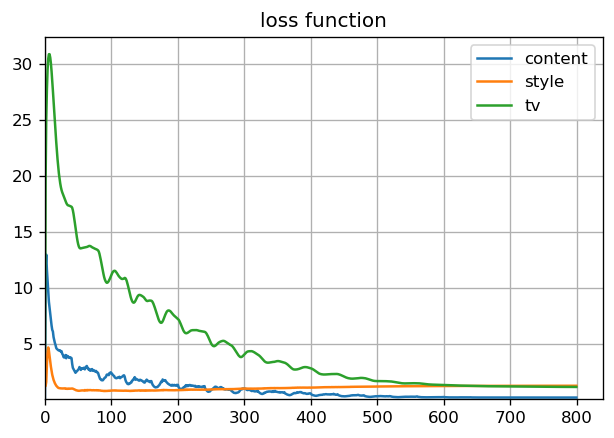

In [15]:
loss = np.array(loss).reshape(-1, 3)
plt.figure(1, dpi=120)
plt.title("loss function")
plt.plot(range(loss.shape[0]), loss)
plt.axis([0, None, 1e-4, None])  # 设置坐标轴范围，使x，y轴看上去只有一个0点
plt.legend(["content", "style", "tv"])
plt.grid(which="major")
plt.show()

### 预览合成图片

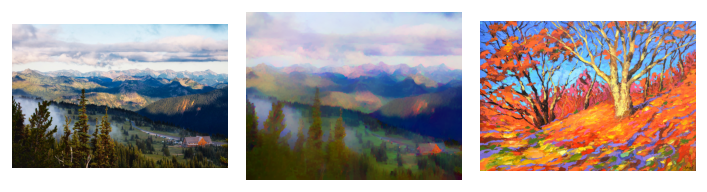

In [16]:
image = postprocess(synthetic_img, device="cpu")
image1 = Image.open(img_content_path)
image2 = Image.open(img_style_path)
img_show(image1, image, image2, col=3)

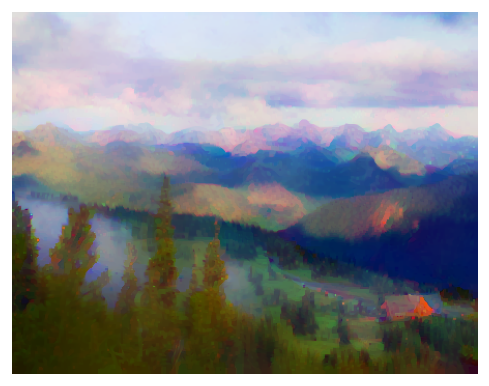

In [17]:
plt.figure(2, dpi=120)
plt.imshow(image)
plt.axis("off")
plt.show()

### 总结
1. 计算图在每次调用`backward()`时被释放，内容/样式图片的特征作为标签值(常量)，只抽取一次特征(vgg19前向传播以一次)，第一次迭代后，常量不会再次计算，并且计算图被释放，所以第二次迭代会报错：`RuntimeError: Trying to backward through the graph a second time`，要使用`detach()`将特征(常量)从计算图中剔除
2. 优化器中的params参数必须是可迭代对象或是字典，所以要训练整个张量要用列表封装，否则是对张量的每一行做迭代，例如`torch.optim.Adam([synthetic_img], 0.3)`
3. process后的输入张量`requires_grad=False`，但是经过特征抽取网络(权重参数`requires_grad=True`)后的输出张量仍然开启了梯度计算
4. 优化参数是合成图像本身，并非网络权重
5. 在计算图中叶子节点不能发生变更，使用`torch.no_grad()`跳出计算图后更改张量
6. 为避免训练时过度关注细节，内容特征选用较上层特征抽取层，样式特征选用底层特征抽取层
7. 张量赋值时指向同一地址，形如x=y，当张量x中的元素执行替换操作时，张量y也随之变化；当x进行算术运算后，x，y就不在指向同一地址，也就是y的值不受x的影响